# Central Hidroeléctrica Yacyretá
## 06 - Modelos ARIMA
### Fecha: 02-Dic-22

In [1]:
# Para que funcione más rápidamente el intellisense
#%config Completer.use_jedi = False

In [2]:
#Cargo numpy y pandas para trabajar con dataframes
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 40})
rcParams["figure.figsize"] = (16,4)


In [3]:
# Imports necesarios para que funcione iplot() como método de pandas
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')

In [4]:
# Calculo las métricas de error
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsoluteScaledError
mae = MeanAbsoluteError()
mse = MeanSquaredError()
rmse = MeanSquaredError(square_root=True)
mase = MeanAbsoluteScaledError()

In [5]:
# Planto una semilla para repetitibilidad
import random
random.seed(170162)
np.random.seed(170162)

In [6]:
# Especifico el nombre del archivo con el dataset unificado de la CHY y el path
path = './datasets/CHY/output/'
file_name = 'CHY_dataset.csv'

In [7]:
# Leo el dataset creado en el notebook anterior
df = pd.read_csv(path + file_name)

In [8]:
# veo cabeza y cola del df
df

,FECHA,COTA_EMBALSE,COTA_RESTITUCION,SALTO,QAFLR,QVBP,QVBAC,QTURB,SINP,SADI
0,2011-01-01,82.04,60.17,21.87,13936.0,0.0,1045.0,11977.0,5391.00,49384.000
1,2011-01-02,82.06,60.17,21.89,13267.0,0.0,1045.0,11863.0,5631.60,48785.000
2,2011-01-03,82.07,60.12,21.95,12670.0,0.0,1045.0,11439.0,6871.60,46573.000
3,2011-01-04,82.08,60.12,21.96,12909.0,0.0,1045.0,11505.0,7460.80,46046.000
4,2011-01-05,82.13,60.08,22.05,13787.0,0.0,1047.0,11455.0,6555.00,46721.000
...,...,...,...,...,...,...,...,...,...,...
3828,2021-06-26,82.78,58.94,23.84,6545.0,0.0,1017.0,5157.0,4388.60,21594.112
3829,2021-06-27,82.78,58.94,23.84,6337.0,0.0,1017.0,5135.0,4188.42,21658.536
3830,2021-06-28,82.79,58.93,23.86,6138.0,0.0,1017.0,5121.0,5165.92,20606.040
3831,2021-06-29,82.79,58.93,23.86,6133.0,0.0,1017.0,5116.0,5427.90,20416.960


In [9]:
# Convierto la columna FECHA de object a datetime64
df['FECHA'] = pd.to_datetime(df['FECHA'])

In [10]:
# Hago que la columna FECHA sea el índice
df.set_index('FECHA', inplace=True)

In [11]:
df

,COTA_EMBALSE,COTA_RESTITUCION,SALTO,QAFLR,QVBP,QVBAC,QTURB,SINP,SADI
FECHA,,,,,,,,,
2011-01-01,82.04,60.17,21.87,13936.0,0.0,1045.0,11977.0,5391.00,49384.000
2011-01-02,82.06,60.17,21.89,13267.0,0.0,1045.0,11863.0,5631.60,48785.000
2011-01-03,82.07,60.12,21.95,12670.0,0.0,1045.0,11439.0,6871.60,46573.000
2011-01-04,82.08,60.12,21.96,12909.0,0.0,1045.0,11505.0,7460.80,46046.000
2011-01-05,82.13,60.08,22.05,13787.0,0.0,1047.0,11455.0,6555.00,46721.000
...,...,...,...,...,...,...,...,...,...
2021-06-26,82.78,58.94,23.84,6545.0,0.0,1017.0,5157.0,4388.60,21594.112
2021-06-27,82.78,58.94,23.84,6337.0,0.0,1017.0,5135.0,4188.42,21658.536
2021-06-28,82.79,58.93,23.86,6138.0,0.0,1017.0,5121.0,5165.92,20606.040


In [12]:
# Chequeo existencia de nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3833 entries, 2011-01-01 to 2021-06-30
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   COTA_EMBALSE      3833 non-null   float64
 1   COTA_RESTITUCION  3833 non-null   float64
 2   SALTO             3833 non-null   float64
 3   QAFLR             3833 non-null   float64
 4   QVBP              3833 non-null   float64
 5   QVBAC             3833 non-null   float64
 6   QTURB             3833 non-null   float64
 7   SINP              3833 non-null   float64
 8   SADI              3833 non-null   float64
dtypes: float64(9)
memory usage: 299.5 KB


In [13]:
df.index
# Veo que el índice no tiene frecuencia asidnada, aunque se ve claramente que es diaria

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
               '2021-06-29', '2021-06-30'],
              dtype='datetime64[ns]', name='FECHA', length=3833, freq=None)

In [14]:
# Le asigno frecuencia diaria
#df = df.asfreq('D')

# Si fuera necesario imputar NAN
df = df.asfreq('D', method='ffill') 

# Vuelvo a ver el índice
df

,COTA_EMBALSE,COTA_RESTITUCION,SALTO,QAFLR,QVBP,QVBAC,QTURB,SINP,SADI
FECHA,,,,,,,,,
2011-01-01,82.04,60.17,21.87,13936.0,0.0,1045.0,11977.0,5391.00,49384.000
2011-01-02,82.06,60.17,21.89,13267.0,0.0,1045.0,11863.0,5631.60,48785.000
2011-01-03,82.07,60.12,21.95,12670.0,0.0,1045.0,11439.0,6871.60,46573.000
2011-01-04,82.08,60.12,21.96,12909.0,0.0,1045.0,11505.0,7460.80,46046.000
2011-01-05,82.13,60.08,22.05,13787.0,0.0,1047.0,11455.0,6555.00,46721.000
...,...,...,...,...,...,...,...,...,...
2021-06-26,82.78,58.94,23.84,6545.0,0.0,1017.0,5157.0,4388.60,21594.112
2021-06-27,82.78,58.94,23.84,6337.0,0.0,1017.0,5135.0,4188.42,21658.536
2021-06-28,82.79,58.93,23.86,6138.0,0.0,1017.0,5121.0,5165.92,20606.040


In [15]:
# Construyo la serie de tiempo SALTO
SALTO = df['SALTO'].squeeze()

In [16]:
SALTO

FECHA
2011-01-01    21.87
2011-01-02    21.89
2011-01-03    21.95
2011-01-04    21.96
2011-01-05    22.05
              ...  
2021-06-26    23.84
2021-06-27    23.84
2021-06-28    23.86
2021-06-29    23.86
2021-06-30    23.89
Freq: D, Name: SALTO, Length: 3834, dtype: float64

<AxesSubplot:xlabel='FECHA'>

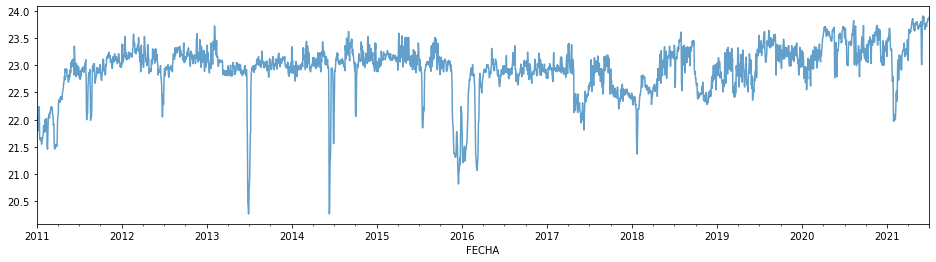

In [17]:
# Ploteo rápido de la variable SALTO
SALTO.plot(figsize=(16,4), alpha=0.7, label=True)

## Estacionariedad

### Condiciones:
1- Media constante

2- Varianza constante

3- Covarianza constante entre períodos de identica distancia

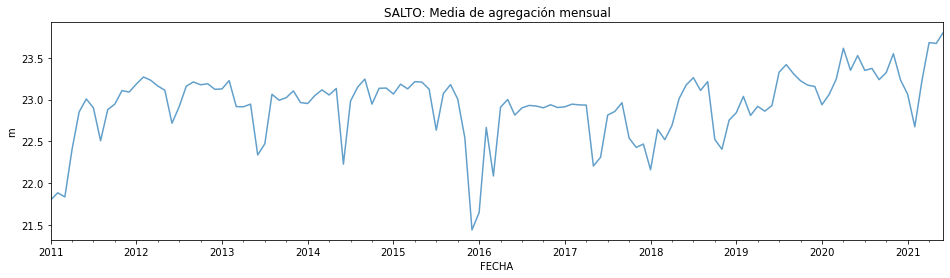

In [18]:
# 1- Creo, para el análisis, series resampleadas mensuales, con agregación media
SALTO_30d_mean = SALTO.resample(rule = 'M').mean()
SALTO_30d_mean.plot(figsize=(16,4), alpha=0.7, title='SALTO: Media de agregación mensual', ylabel='m');

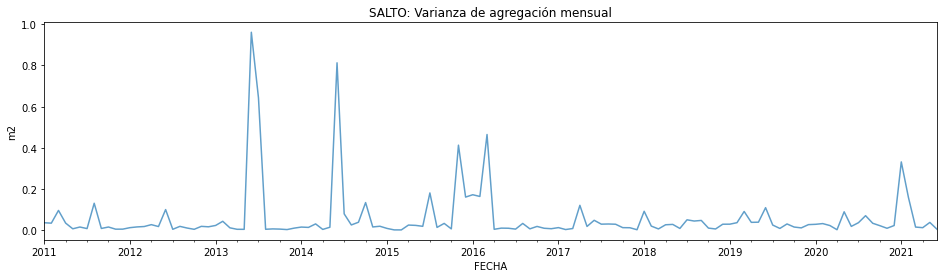

In [19]:
# 2- Creo, para el análisis, series resampleadas mensuales, con agregación varianza
SALTO_30d_var = SALTO.resample(rule = 'M').var()
SALTO_30d_var.plot(figsize=(16,4), alpha=0.7, title='SALTO: Varianza de agregación mensual', ylabel='m2');

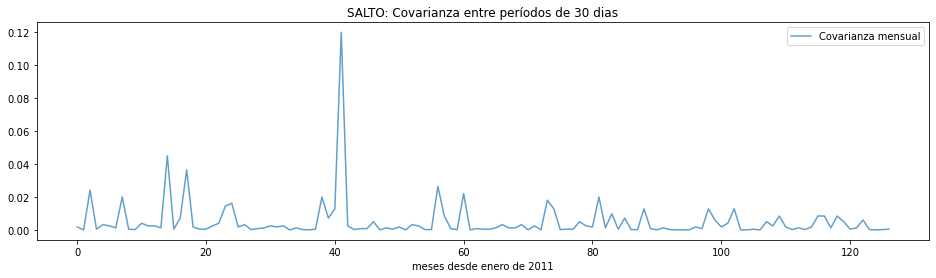

In [20]:
# 3- Calculo la covarianca de cada mes con el del mes siguiente
SALTO_30d_cov_list = []
i = 0
periodo = 30
while (i+periodo) <= len(SALTO):
    SALTO_30d_cov_list.append(SALTO[i:i+periodo].cov(SALTO[i+periodo-2:i+periodo+periodo-2]))
    i=i+periodo

# Convierto a pandas dataframe
SALTO_30d_cov = pd.DataFrame(SALTO_30d_cov_list, columns=['Covarianza mensual'])

# Ploteo
SALTO_30d_cov.plot(figsize=(16,4), alpha=0.7, title='SALTO: Covarianza entre períodos de 30 dias', xlabel='meses desde enero de 2011');

## ARIMA - Orden del modelo

In [21]:
from sktime.registry import all_estimators

In [22]:
# all_estimators returns list of pairs - data frame conversion for pretty printing
# all_estimators("forecaster", as_dataframe=True)

In [23]:
# Dado que demostramos que la serie es NO_ESTACIONARIA, habrá que diferenciarla al menos una vez, d=1

In [24]:
# Diferencio la serie en un orden
SALTO_diff = SALTO.diff(1).dropna()

#### Autocorrelation Plot

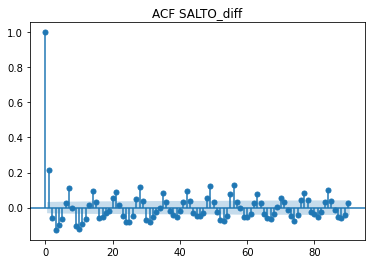

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(SALTO_diff, lags=90, title='ACF SALTO_diff');

#### Partial-Autocorrelation Plot

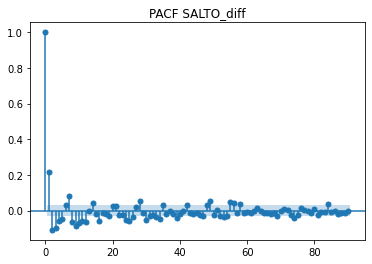

In [26]:
plot_pacf(SALTO_diff, lags=90, title='PACF SALTO_diff');

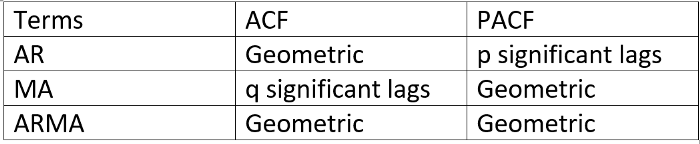

In [27]:
# De los diagramas se ve que se trataría, para SALTO_diff, de un modelo ARMA de orden p=1 y q=1 
# q=1 para SALTO, ya que diferenciamos una vez
# Aún diferenciada, se ve estacionalidad de 7 períodos (semanal)

### Descomposición de SALTO_diff

In [28]:
# Descompongo la serie diferenciada SALTO_diff

In [29]:
import statsmodels.api as sm
SALTO_diff_descomposicion = sm.tsa.seasonal_decompose(SALTO_diff, model='additive')

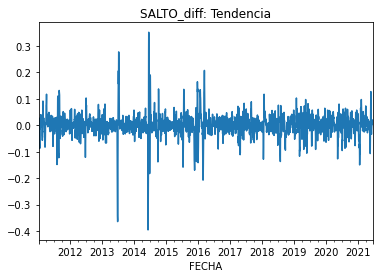

In [30]:
SALTO_diff_descomposicion.trend.plot(title='SALTO_diff: Tendencia');

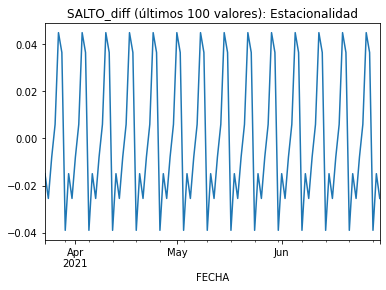

In [31]:
SALTO_diff_descomposicion.seasonal[-100:].plot(title='SALTO_diff (últimos 100 valores): Estacionalidad');

### Tendencia

#### Autocorrelation Plot

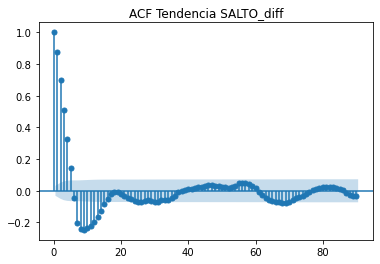

In [32]:
plot_acf(SALTO_diff_descomposicion.trend.dropna(), lags=90, title='ACF Tendencia SALTO_diff');

#### Partial-Autocorrelation Plot

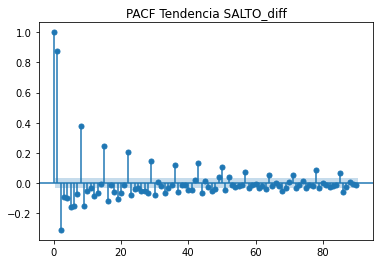

In [33]:
plot_pacf(SALTO_diff_descomposicion.trend.dropna(), lags=90, title='PACF Tendencia SALTO_diff');

In [34]:
# SALTO => Modelo ARI
#d = 1 (por eso diferenciamos y trabajamos con SALTO_diff)
#q = 0 y p = 2 (del diagrama de PAC)

### Estacionalidad

#### Autocorrelation Plot

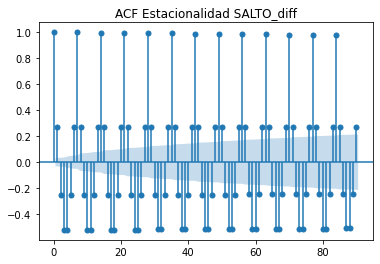

In [35]:
plot_acf(SALTO_diff_descomposicion.seasonal.dropna(), lags=90, title='ACF Estacionalidad SALTO_diff');

#### Partial-Autocorrelation Plot

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



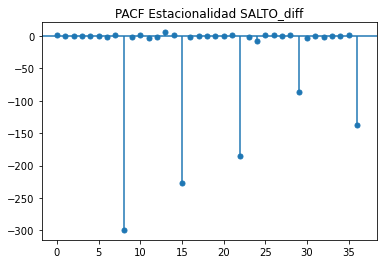

In [36]:
plot_pacf(SALTO_diff_descomposicion.seasonal.dropna(), title='PACF Estacionalidad SALTO_diff');

In [37]:
# SALTO (estacional) => Modelo ARIMA
#D = 1 (por eso diferenciamos y trabajamos con SALTO_diff)
#Q = 0 y P = 1 (del diagrama de PAC)

In [38]:
## NO ESTÄ TERMINADO EL ANÁLISIS

### AUTOARIMA

In [39]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

#### Pronóstico a 7 días

In [40]:
# Defino el predictor AutoArima, con estacionalidad 7 días
fh_dias = 7

forecaster = AutoARIMA(sp=7, suppress_warnings=True)

# Pronostico los últimos 7 días
SALTO_train, SALTO_test = temporal_train_test_split(SALTO, test_size=fh_dias)

# Ajusto / Entreno el modelo
forecaster.fit(SALTO_train)

AutoARIMA(sp=7, suppress_warnings=True)

In [41]:
forecaster.check_is_fitted()

In [42]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 3827
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                3074.781
Date:                                Mon, 13 Jun 2022   AIC                          -6131.562
Time:                                        00:41:14   BIC                          -6075.316
Sample:                                             0   HQIC                         -6111.579
                                               - 3827                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.107e-05   3.16e-05     -0.350      0.726    -7.3e-05    5.08e-05
ar.L1          1.1534      0.032     35.996      0.000       1.091       1.216
ar.L2         -0.2661      0.012    -22.701      0.000      -0.289      -0.243
ma.L1         -0.8993      0.032    -28.536      0.000      -0.961      -0.838
ar.S.L7        0.2359      0.309      0.764      0.445      -0.369       0.841
ar.S.L14       0.6941      0.293      2.365      0.018       0.119       1.269
ma.S.L7       -0.1595      0.304     -0.524      0.600      -0.756       0.437
ma.S.L14      -0.6635      0.268     -2.479      0.013      -1.188      -0.139
sigma2         0.0115      0.000     93.684      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   7.11   Jarque-Bera (JB):             19771.79
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.81
Prob(H) (two-sided):                  0.19   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# to obtain the fitted parameters, run
forecaster.get_fitted_params()

{'intercept': -1.1067341703780445e-05,
 'ar.L1': 1.1534125723339965,
 'ar.L2': -0.2661035495875433,
 'ma.L1': -0.8993379641832389,
 'ar.S.L7': 0.23592235203379153,
 'ar.S.L14': 0.694144253709023,
 'ma.S.L7': -0.15949764079585238,
 'ma.S.L14': -0.6634777985241188,
 'sigma2': 0.011462508846569545,
 'aic': -6131.5619431260675,
 'aicc': -6131.514773314747,
 'bic': -6075.315766776066,
 'hqic': -6111.579032489151}

In [44]:
forecaster.get_params()

{'D': None,
 'alpha': 0.05,
 'd': None,
 'error_action': 'warn',
 'information_criterion': 'aic',
 'max_D': 1,
 'max_P': 2,
 'max_Q': 2,
 'max_d': 2,
 'max_order': 5,
 'max_p': 5,
 'max_q': 5,
 'maxiter': 50,
 'method': 'lbfgs',
 'n_fits': 10,
 'n_jobs': 1,
 'offset_test_args': None,
 'out_of_sample_size': 0,
 'random': False,
 'random_state': None,
 'scoring': 'mse',
 'scoring_args': None,
 'seasonal': True,
 'seasonal_test': 'ocsb',
 'seasonal_test_args': None,
 'sp': 7,
 'start_P': 1,
 'start_Q': 1,
 'start_p': 2,
 'start_params': None,
 'start_q': 2,
 'stationary': False,
 'stepwise': True,
 'suppress_warnings': True,
 'test': 'kpss',
 'trace': False,
 'trend': None,
 'with_intercept': True}

In [45]:
fh = ForecastingHorizon(SALTO_test.index, is_relative=False)
#fh = ForecastingHorizon(np.arange(1, len(SALTO_test.index)), is_relative=True)
SALTO_pred = forecaster.predict(fh)

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\forecasting\base\_fh.py:486: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\forecasting\base\_fh.py:496: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:68: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:71: FutureWarning:

Timestamp.freqstr is d

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='SALTO'>)

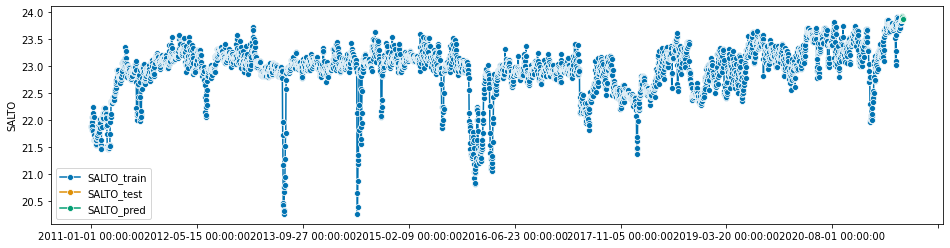

In [46]:
# Ploteo SALTO_train, SALTO_test y SALTO_pred 
plot_series(SALTO_train, SALTO_test, SALTO_pred, labels=["SALTO_train", "SALTO_test", "SALTO_pred"])

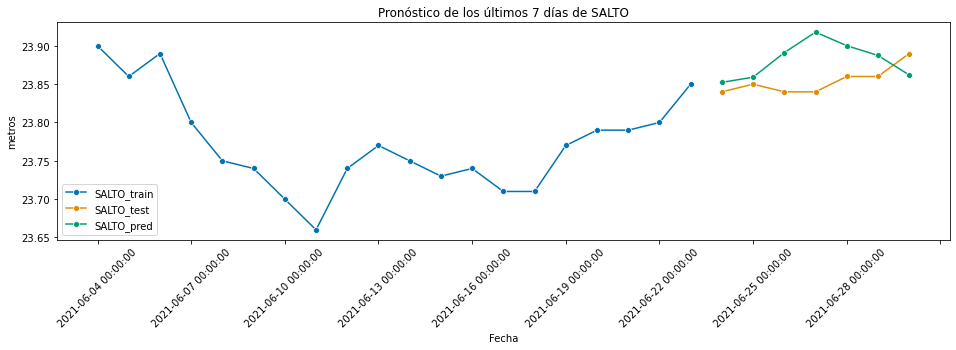

In [47]:
# Ploteo desde los últimos 20 valores de SALTO_train para que se vea mejor las SALTO_test y SALTO_pred
fig, ax = plot_series(SALTO_train[-20:], SALTO_test, SALTO_pred, labels=["SALTO_train", "SALTO_test", "SALTO_pred"], 
            x_label='Fecha', y_label='metros')
ax.set_title('Pronóstico de los últimos 7 días de SALTO')
ax.tick_params(axis='x', labelrotation = 45)

In [48]:
# Ploteo los resultados
pd.concat([SALTO.iloc[int(-1.5*fh_dias):], SALTO_pred], keys=['SALTO_test', 'SALTO_pred'], axis=1).iplot(
    mode='lines+markers', size=5.0
    ,title='AutoARIMA - Pronóstico a ' + str(fh_dias) + ' días' \
    + ' / MAE: ' + f"{mae(SALTO_test, SALTO_pred):.4f}" + 'm, ' + 'RMSE: ' \
                + f"{rmse(SALTO_test, SALTO_pred):.4f}" + 'm'
    ,yTitle='metros'
    ,xTitle='Fecha'
    ,dimensions=(950, 300)
    )

In [49]:
# Creo un dataframe para graficar las diferencias entre los valores reales y los pronosticados
df_test_pred = pd.DataFrame(columns=['SALTO_test', 'SALTO_pred', 'delta'], index=SALTO_test.index)
df_test_pred['SALTO_test'] = SALTO_test
df_test_pred['SALTO_pred'] = SALTO_pred
df_test_pred['delta'] = df_test_pred['SALTO_test'] - df_test_pred['SALTO_pred']

# Quito la parte de las horas al índice
df_test_pred.index = df_test_pred.index.date 

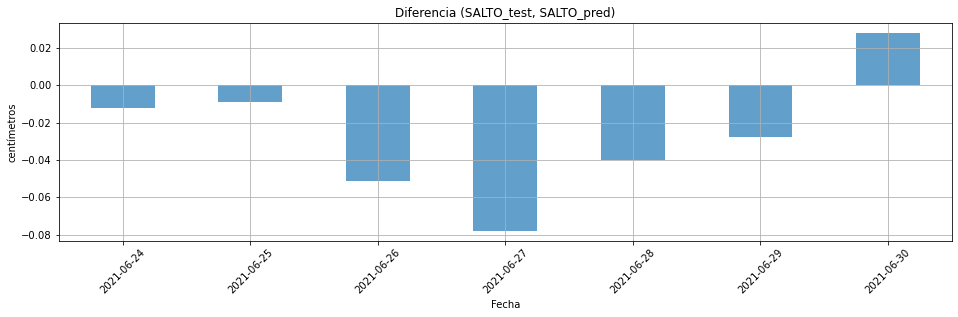

In [50]:
# Ploteo el diagrama de barras
ax = df_test_pred['delta'].plot(figsize=(16,4), alpha=0.7, grid=True, kind='bar',  ylabel='centímetros', 
                           xlabel='Fecha', title='Diferencia (SALTO_test, SALTO_pred)')
ax.tick_params(axis='x', labelrotation = 45)

In [51]:
# Ploteo los resultados
df_test_pred.iplot(kind='bar'
                   ,keys=['delta']
                   ,color=['lightblue']
                   ,dimensions=(950, 300)
                   ,xTitle='Fecha'
                   ,yTitle='metros'
                   ,title='Pronostico Ingenuo a ' + str(fh_dias) + ' días, diferencia (SALTO_test, SALTO_pred)'
                  )


In [52]:
error_metrics={'MAE': mae(SALTO_test, SALTO_pred), 
               'MSE': mse(SALTO_test, SALTO_pred), 
               'RMSE': rmse(y_true=SALTO_test, y_pred=SALTO_pred), 
               'MASE': mase(y_true=SALTO_test, y_pred=SALTO_pred, y_train=SALTO_train)}
error_metrics

{'MAE': 0.03516616914389102,
 'MSE': 0.0017245912361430664,
 'RMSE': 0.041528198084471064,
 'MASE': 0.46334376728606275}

In [53]:
# Imprimo solo el mae y el rmse en centímetros
for key, value in error_metrics.items():
    if key in ['MAE', 'RMSE']:
        print(key, ':',"{0:0.4f}".format(value*100), ' cm')

MAE : 3.5166  cm
RMSE : 4.1528  cm


#### Pronóstico a 56 días

In [54]:
# Defino el predictor AutoArima, con estacionalidad 7 días
fh_dias = 56

forecaster = AutoARIMA(sp=7, suppress_warnings=True)

# Pronostico los últimos 7 días
SALTO_train, SALTO_test = temporal_train_test_split(SALTO, test_size=fh_dias)

# Ajusto / Entreno el modelo
forecaster.fit(SALTO_train)

AutoARIMA(sp=7, suppress_warnings=True)

In [55]:
forecaster.check_is_fitted()

In [56]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3778
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                3045.868
Date:                           Mon, 13 Jun 2022   AIC                          -6077.736
Time:                                   00:46:30   BIC                          -6034.080
Sample:                                        0   HQIC                         -6062.216
                                          - 3778                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.496e-06   6.67e-06      0.674      0.500   -8.57e-06    1.76e-05
ar.L1          1.1707      0.013     88.902      0.000       1.145       1.196
ar.L2         -0.2347      0.010    -22.592      0.000      -0.255      -0.214
ma.L1         -0.9711      0.010   -100.243      0.000      -0.990      -0.952
ar.S.L7        0.9453      0.013     74.094      0.000       0.920       0.970
ma.S.L7       -0.8780      0.019    -45.344      0.000      -0.916      -0.840
sigma2         0.0113      0.000     95.169      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             23400.59
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.93
Prob(H) (two-sided):                  0.63   Kurtosis:                        15.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
# to obtain the fitted parameters, run
forecaster.get_fitted_params()

{'intercept': 4.4961410026193356e-06,
 'ar.L1': 1.1706805676345746,
 'ar.L2': -0.2346893713990017,
 'ma.L1': -0.9711306339113038,
 'ar.S.L7': 0.9453387112323661,
 'ma.S.L7': -0.8780345172672525,
 'sigma2': 0.011343350870536412,
 'aic': -6077.7363457169085,
 'aicc': -6077.706629611841,
 'bic': -6034.079548457921,
 'hqic': -6062.215973768298}

In [58]:
forecaster.get_params()

{'D': None,
 'alpha': 0.05,
 'd': None,
 'error_action': 'warn',
 'information_criterion': 'aic',
 'max_D': 1,
 'max_P': 2,
 'max_Q': 2,
 'max_d': 2,
 'max_order': 5,
 'max_p': 5,
 'max_q': 5,
 'maxiter': 50,
 'method': 'lbfgs',
 'n_fits': 10,
 'n_jobs': 1,
 'offset_test_args': None,
 'out_of_sample_size': 0,
 'random': False,
 'random_state': None,
 'scoring': 'mse',
 'scoring_args': None,
 'seasonal': True,
 'seasonal_test': 'ocsb',
 'seasonal_test_args': None,
 'sp': 7,
 'start_P': 1,
 'start_Q': 1,
 'start_p': 2,
 'start_params': None,
 'start_q': 2,
 'stationary': False,
 'stepwise': True,
 'suppress_warnings': True,
 'test': 'kpss',
 'trace': False,
 'trend': None,
 'with_intercept': True}

In [59]:
fh = ForecastingHorizon(SALTO_test.index, is_relative=False)
#fh = ForecastingHorizon(np.arange(1, len(SALTO_test.index)), is_relative=True)
SALTO_pred = forecaster.predict(fh)

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\forecasting\base\_fh.py:486: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\forecasting\base\_fh.py:496: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:68: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\josel\anaconda3\envs\tesis\lib\site-packages\sktime\utils\datetime.py:71: FutureWarning:

Timestamp.freqstr is d

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='SALTO'>)

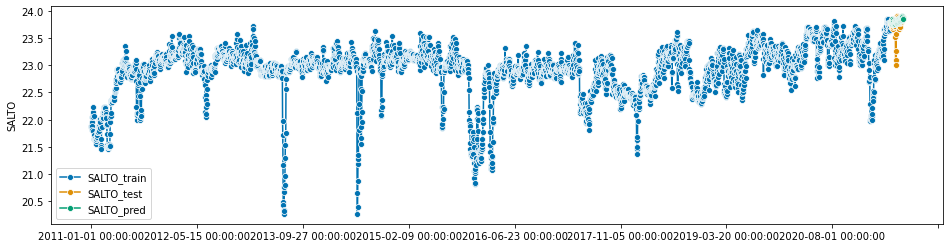

In [60]:
# Ploteo SALTO_train, SALTO_test y SALTO_pred 
plot_series(SALTO_train, SALTO_test, SALTO_pred, labels=["SALTO_train", "SALTO_test", "SALTO_pred"])

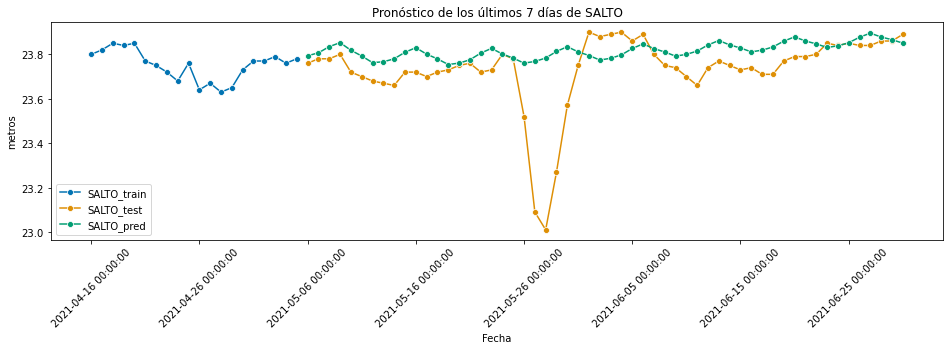

In [61]:
# Ploteo desde los últimos 20 valores de SALTO_train para que se vea mejor las SALTO_test y SALTO_pred
fig, ax = plot_series(SALTO_train[-20:], SALTO_test, SALTO_pred, labels=["SALTO_train", "SALTO_test", "SALTO_pred"], 
            x_label='Fecha', y_label='metros')
ax.set_title('Pronóstico de los últimos 7 días de SALTO')
ax.tick_params(axis='x', labelrotation = 45)

In [63]:
# Ploteo los resultados
pd.concat([SALTO.iloc[int(-1.5*fh_dias):], SALTO_pred], keys=['SALTO_test', 'SALTO_pred'], axis=1).iplot(
    mode='lines+markers', size=5.0
    ,title='AutoARIMA - Pronóstico a ' + str(fh_dias) + ' días' \
    + ' / MAE: ' + f"{mae(SALTO_test, SALTO_pred):.4f}" + 'm, ' + 'RMSE: ' \
                + f"{rmse(SALTO_test, SALTO_pred):.4f}" + 'm'
    ,yTitle='metros'
    ,xTitle='Fecha'
    ,dimensions=(950, 300)
    )

In [64]:
# Creo un dataframe para graficar las diferencias entre los valores reales y los pronosticados
df_test_pred = pd.DataFrame(columns=['SALTO_test', 'SALTO_pred', 'delta'], index=SALTO_test.index)
df_test_pred['SALTO_test'] = SALTO_test
df_test_pred['SALTO_pred'] = SALTO_pred
df_test_pred['delta'] = df_test_pred['SALTO_test'] - df_test_pred['SALTO_pred']

# Quito la parte de las horas al índice
df_test_pred.index = df_test_pred.index.date 

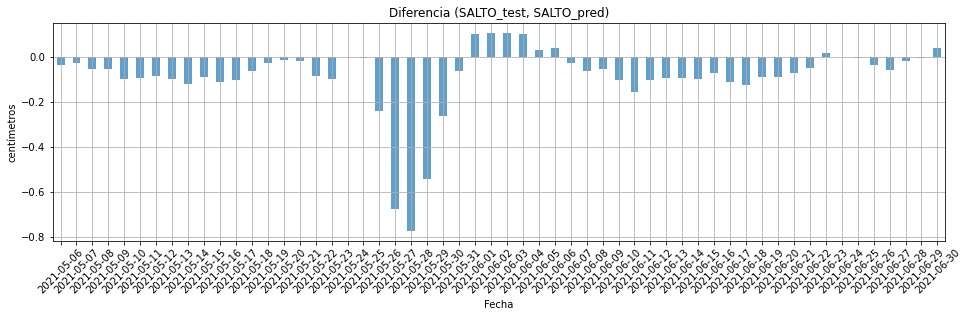

In [65]:
# Ploteo el diagrama de barras
ax = df_test_pred['delta'].plot(figsize=(16,4), alpha=0.7, grid=True, kind='bar',  ylabel='centímetros', 
                           xlabel='Fecha', title='Diferencia (SALTO_test, SALTO_pred)')
ax.tick_params(axis='x', labelrotation = 45)

In [66]:
# Ploteo los resultados
df_test_pred.iplot(kind='bar'
                   ,keys=['delta']
                   ,color=['lightblue']
                   ,dimensions=(950, 300)
                   ,xTitle='Fecha'
                   ,yTitle='metros'
                   ,title='Pronostico Ingenuo a ' + str(fh_dias) + ' días, diferencia (SALTO_test, SALTO_pred)'
                  )


In [67]:
error_metrics={'MAE': mae(SALTO_test, SALTO_pred), 
               'MSE': mse(SALTO_test, SALTO_pred), 
               'RMSE': rmse(y_true=SALTO_test, y_pred=SALTO_pred), 
               'MASE': mase(y_true=SALTO_test, y_pred=SALTO_pred, y_train=SALTO_train)}
error_metrics

{'MAE': 0.10478779039992915,
 'MSE': 0.031770320635069675,
 'RMSE': 0.178242308768344,
 'MASE': 1.3763031065150462}

In [69]:
# Imprimo solo el mae y el rmse en centímetros
for key, value in error_metrics.items():
    if key in ['MAE', 'RMSE']:
        print(key, ':',"{0:0.4f}".format(value), 'm')

MAE : 0.1048 m
RMSE : 0.1782 m


# ¡Fin del Notebook!